<a href="https://colab.research.google.com/github/Mandloi1/projectwork/blob/master/Flight_Delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Importing Libs
import os
import numpy as np # Linear Algebra
import pandas as pd # Data Manipulation
pd.set_option('MAX_ROWS', None) # Setting pandas to display a N number of columns
from collections import Counter # Data Manipulation
import seaborn as sns # Data Viz
import matplotlib.pyplot as plt # Data Viz
from sklearn import tree # Modelling a tree
from sklearn.impute import SimpleImputer # Perform Imputation
from imblearn.over_sampling import SMOTE # Perform oversampling
from sklearn.preprocessing import OneHotEncoder # Perform OneHotEnconding
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict # Cross Validation
from sklearn.linear_model import LogisticRegression # Modelling
from sklearn.metrics import classification_report, roc_auc_score,precision_score,recall_score # Evaluating the Model


#warnings
import warnings
warnings.filterwarnings("ignore")

In [36]:
import os
for dirname, _, filenames in os.walk('jan_2019_ontime.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [37]:
# Collecting data
df_2019 = pd.read_csv("./drive/My Drive/Jan_2019_ontime.csv")
df_2020 = pd.read_csv("./drive/My Drive/Jan_2020_ontime.csv")
df_2019.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,10397,1039707,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,11193,1119302,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,11193,1119302,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,10397,1039707,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,11778,1177801,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [38]:
#Creating year indicator.
df_2019['year'] = 2019
df_2020['year'] = 2020

#Checking if the bases have the same columns
print(set(df_2020.columns) == set(df_2019.columns))

#Generating the unique base
dataset = pd.concat([df_2019,df_2020])
print(dataset.shape)
print('\n')
dataset.head()

True
(1191331, 23)




,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21,year
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,10397,1039707,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN,2019
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,11193,1119302,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN,2019
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,11193,1119302,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN,2019
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,10397,1039707,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN,2019
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,11778,1177801,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN,2019


In [39]:
data = dataset.drop(['OP_UNIQUE_CARRIER','OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21'], axis=1)
data = data.set_index('OP_CARRIER_FL_NUM')
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year
OP_CARRIER_FL_NUM,,,,,,,,,,,,,
3280,1,2,GNV,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,2019
3281,1,2,MSP,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,2019
3282,1,2,DTW,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,2019
3283,1,2,TLH,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,2019
3284,1,2,ATL,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,2019


In [40]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year
OP_CARRIER_FL_NUM,,,,,,,,,,,,,
3280,1,2,GNV,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,2019
3281,1,2,MSP,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,2019
3282,1,2,DTW,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,2019
3283,1,2,TLH,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,2019
3284,1,2,ATL,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,2019


In [41]:
#Dataframe summary
pd.DataFrame({'unicos':data.nunique(),
              'missing': data.isna().sum()/data.count(),
              'tipo':data.dtypes})

,unicos,missing,tipo
DAY_OF_MONTH,31,0.000000,int64
DAY_OF_WEEK,7,0.000000,int64
ORIGIN,353,0.000000,object
DEST,353,0.000000,object
DEP_TIME,1440,0.019700,float64
DEP_DEL15,2,0.019733,float64
DEP_TIME_BLK,19,0.000000,object
ARR_TIME,1440,0.020679,float64
ARR_DEL15,2,0.022399,float64
CANCELLED,2,0.000000,float64


In [42]:
#Missing values
data.dropna(inplace=True)

#Transformation of data types
colunas = ['DAY_OF_WEEK','DAY_OF_MONTH','DEP_DEL15','ARR_DEL15','CANCELLED','DIVERTED']
for col in colunas:
  data[col] = data[col].astype('category') 

#Discretization
data['DISTANCE_cat'] = pd.qcut(data['DISTANCE'], q=4)

In [43]:
#Dataframe summary after pre-processing
pd.DataFrame({'unicos':data.nunique(),
              'missing': data.isna().mean()*100,
              'tipo':data.dtypes})

,unicos,missing,tipo
DAY_OF_MONTH,31,0.0,category
DAY_OF_WEEK,7,0.0,category
ORIGIN,353,0.0,object
DEST,353,0.0,object
DEP_TIME,1440,0.0,float64
DEP_DEL15,2,0.0,category
DEP_TIME_BLK,19,0.0,object
ARR_TIME,1440,0.0,float64
ARR_DEL15,2,0.0,category
CANCELLED,1,0.0,category


In [44]:
#check data
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year,DISTANCE_cat
OP_CARRIER_FL_NUM,,,,,,,,,,,,,,
3280,1,2,GNV,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]"
3281,1,2,MSP,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,2019,"(368.0, 641.0]"
3282,1,2,DTW,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,2019,"(30.999, 368.0]"
3283,1,2,TLH,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,2019,"(30.999, 368.0]"
3284,1,2,ATL,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,2019,"(368.0, 641.0]"


Text(0, 0.5, 'Freq')

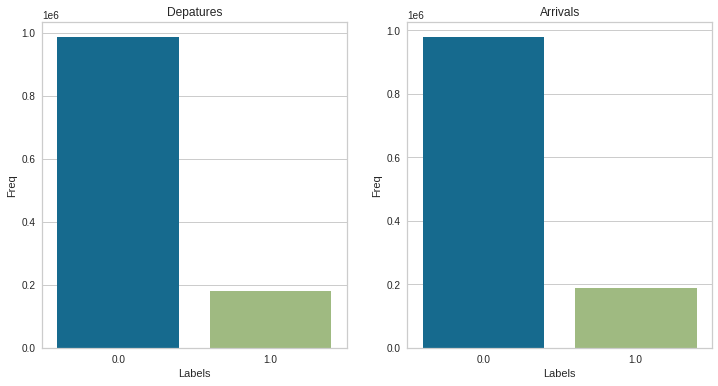

In [45]:
#The concentration of delay and timely arrivals both on departure and on arrival?
f, (ax,ax1) = plt.subplots(1,2, figsize=(12,6))
dep = sns.countplot(data['DEP_DEL15'], ax=ax)
dep.set_title('Depatures')
dep.set_xlabel('Labels')
dep.set_ylabel('Freq')

arr = sns.countplot(data['ARR_DEL15'], ax=ax1)
arr.set_title('Arrivals')
arr.set_xlabel('Labels')
arr.set_ylabel('Freq')

Text(0, 0.5, 'Freq')

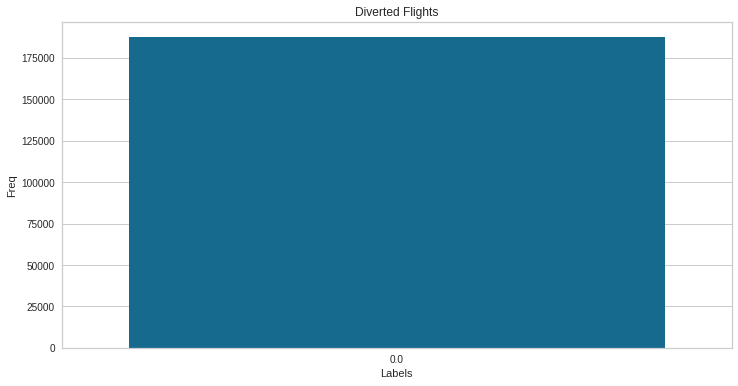

In [46]:
# Percentage of delayed flights that are canceled or diverted?
voos_atrasados = data.loc[data['ARR_DEL15'] == 1,['DIVERTED']]


f, ax= plt.subplots(figsize=(12,6))

#Desvios
desv = sns.countplot(voos_atrasados['DIVERTED'], ax=ax)
desv.set_title('Diverted Flights')
desv.set_xlabel('Labels')
desv.set_ylabel('Freq')

In [47]:
# Delays due to day_of_week and day_of_month?

week = data[['DAY_OF_WEEK','ARR_DEL15']].groupby('DAY_OF_WEEK').sum().sort_values(by='ARR_DEL15',ascending=False)
week['PERCENTUAL'] = week['ARR_DEL15']/(week['ARR_DEL15'].sum())*100
month = data[['DAY_OF_MONTH','ARR_DEL15']].groupby('DAY_OF_MONTH').sum().sort_values(by='ARR_DEL15',ascending=False)
month['PERCENTUAL'] = month['ARR_DEL15']/(month['ARR_DEL15'].sum())*100

print('>> Delayed flights by weekday<<')
print(week)
print('\n')
print('>> Delayed flights by monthday <<')
print(month)

>> Delayed flights by weekday<<
             ARR_DEL15  PERCENTUAL
DAY_OF_WEEK                       
4              34414.0   18.353448
5              30724.0   16.385522
3              27485.0   14.658119
1              25291.0   13.488030
7              23988.0   12.793122
6              23084.0   12.311007
2              22521.0   12.010752


>> Delayed flights by monthday <<
              ARR_DEL15  PERCENTUAL
DAY_OF_MONTH                       
24               8594.0    4.583296
2                8009.0    4.271307
23               7810.0    4.165178
18               7717.0    4.115580
3                7523.0    4.012117
17               7518.0    4.009450
16               7252.0    3.867589
11               6959.0    3.711328
4                6942.0    3.702262
21               6877.0    3.667596
31               6820.0    3.637198
6                6418.0    3.422806
13               6299.0    3.359341
25               6254.0    3.335342
1                6094.0    3.250012
10   

In [48]:
# Concentration of delays due to 'DEP_TIME_BLK'?
time_blk = data[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',ascending=False)
time_blk['PERCENTUAL'] = time_blk['ARR_DEL15']/(time_blk['ARR_DEL15'].sum())*100
time_blk

,ARR_DEL15,PERCENTUAL
DEP_TIME_BLK,,
1700-1759,14875.0,7.933037
1800-1859,14020.0,7.477054
1600-1659,13292.0,7.088802
1500-1559,12760.0,6.805079
1900-1959,12640.0,6.741082
1400-1459,12618.0,6.729349
1200-1259,11761.0,6.272299
1100-1159,11181.0,5.962977
1300-1359,11101.0,5.920312


In [49]:
# Which 'Origin' airport stands out in delay?
origin_later = data[['ORIGIN','DEP_DEL15']].groupby('ORIGIN').sum().sort_values(by='DEP_DEL15',ascending=False)
origin_later['PERCENTUAL'] = origin_later['DEP_DEL15']/(origin_later['DEP_DEL15'].sum())*100
origin_later.head()

,DEP_DEL15,PERCENTUAL
ORIGIN,,
ORD,10639.0,5.918710
DFW,8559.0,4.761560
ATL,7737.0,4.304264
DEN,6154.0,3.423606
CLT,5717.0,3.180493


In [50]:
# Which airport of Destination stands out in delays?
dest_later = data[['DEST','ARR_DEL15']].groupby('DEST').sum().sort_values(by='ARR_DEL15',ascending=False)
dest_later['PERCENTUAL'] = dest_later['ARR_DEL15']/(dest_later['ARR_DEL15'].sum())*100
dest_later.head()

,ARR_DEL15,PERCENTUAL
DEST,,
ORD,10170.0,5.423798
DFW,8667.0,4.622227
ATL,7263.0,3.873455
LGA,7077.0,3.774259
SFO,6114.0,3.260678


In [51]:
# Helper function to create ARR_TIME_BLOCK
def arr_time(x):

  if x >= 600 and x <= 659:
    return '0600-0659'
  elif x>=1400 and x<=1459:
    return '1400-1459'
  elif x>=1200 and x<=1259:
    return '1200-1259'
  elif x>=1500 and x<=1559:
    return '1500-1559'
  elif x>=1900 and x<=1959:
    return '1900-1959'
  elif x>=900 and x<=959:
    return '0900-0959'
  elif x>=1000 and x<=1059:
    return  '1000-1059'
  elif x>=2000 and x<=2059:
    return '2000-2059'
  elif x>=1300 and x<=1359:
    return '1300-1359'
  elif x>=1100 and x<=1159:
    return '1100-1159'
  elif x>=800 and x<=859:
    return '0800-0859'
  elif x>=2200 and x<=2259:
    return '2200-2259'
  elif x>=1600 and x<=1659:
    return '1600-1659'
  elif x>=1700 and x<=1759:
    return '1700-1759'
  elif x>=2100 and x<=2159:
    return '2100-2159'
  elif x>=700 and x<=759:
    return '0700-0759'
  elif x>=1800 and x<=1859:
    return '1800-1859'
  elif x>=1 and x<=559:
    return '0001-0559'
  elif x>=2300 and x<=2400:
    return '2300-2400'

In [52]:
# We can create ARR_TIME_BLOCK.
data['ARR_TIME'] = data['ARR_TIME'].astype('int')
data['ARR_TIME_BLOCK'] = data['ARR_TIME'].apply(lambda x :arr_time(x))
data.reset_index(inplace=True)
data.head()

,OP_CARRIER_FL_NUM,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year,DISTANCE_cat,ARR_TIME_BLOCK
0,3280,1,2,GNV,ATL,601.0,0.0,0600-0659,722,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759
1,3281,1,2,MSP,CVG,1359.0,0.0,1400-1459,1633,0.0,0.0,0.0,596.0,2019,"(368.0, 641.0]",1600-1659
2,3282,1,2,DTW,CVG,1215.0,0.0,1200-1259,1329,0.0,0.0,0.0,229.0,2019,"(30.999, 368.0]",1300-1359
3,3283,1,2,TLH,ATL,1521.0,0.0,1500-1559,1625,0.0,0.0,0.0,223.0,2019,"(30.999, 368.0]",1600-1659
4,3284,1,2,ATL,FSM,1847.0,0.0,1900-1959,1940,0.0,0.0,0.0,579.0,2019,"(368.0, 641.0]",1900-1959


In [53]:
# Amount of delays within a DEP_TIME_BLK.
count_time_blk = data[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',ascending=False)
count_time_blk.reset_index(inplace=True)
count_time_blk.head()
data1 = data.merge(count_time_blk, left_on='DEP_TIME_BLK', right_on='DEP_TIME_BLK') 
data1.rename({'ARR_DEL15_y':'quant_dep_time_blk','ARR_DEL15_x':'ARR_DEL15' }, inplace=True, axis=1)
data1.head()

,OP_CARRIER_FL_NUM,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year,DISTANCE_cat,ARR_TIME_BLOCK,quant_dep_time_blk
0,3280,1,2,GNV,ATL,601.0,0.0,0600-0659,722,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759,8334.0
1,3290,1,2,CAK,ATL,557.0,0.0,0600-0659,737,0.0,0.0,0.0,528.0,2019,"(368.0, 641.0]",0700-0759,8334.0
2,3330,1,2,GTR,ATL,636.0,0.0,0600-0659,850,0.0,0.0,0.0,241.0,2019,"(30.999, 368.0]",0800-0859,8334.0
3,3335,1,2,LFT,ATL,553.0,0.0,0600-0659,827,0.0,0.0,0.0,503.0,2019,"(368.0, 641.0]",0800-0859,8334.0
4,3349,1,2,AGS,ATL,601.0,0.0,0600-0659,704,0.0,0.0,0.0,143.0,2019,"(30.999, 368.0]",0700-0759,8334.0


In [54]:
# Number of delays DEP_DEL15 per ORIGIN.
count_later_origin = data[['ORIGIN','DEP_DEL15']].groupby('ORIGIN').sum().sort_values(by='DEP_DEL15',ascending=False)
count_later_origin.reset_index(inplace=True)
count_later_origin.head()
data2 = data1.merge(count_later_origin, left_on='ORIGIN', right_on='ORIGIN')
data2.rename({'DEP_DEL15_y':'count_later_origin','DEP_DEL15_x':'DEP_DEL15' }, inplace=True, axis=1)
data2.head() 

,OP_CARRIER_FL_NUM,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year,DISTANCE_cat,ARR_TIME_BLOCK,quant_dep_time_blk,count_later_origin
0,3280,1,2,GNV,ATL,601.0,0.0,0600-0659,722,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0
1,3831,1,2,GNV,MIA,621.0,0.0,0600-0659,734,0.0,0.0,0.0,294.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0
2,3426,2,3,GNV,ATL,546.0,0.0,0600-0659,655,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0600-0659,8334.0,114.0
3,3426,3,4,GNV,ATL,555.0,0.0,0600-0659,718,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0
4,3831,3,4,GNV,MIA,619.0,0.0,0600-0659,723,0.0,0.0,0.0,294.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0


In [55]:
# Number of delays ARR_DEL15 per DEST.
count_later_dest = data[['DEST','ARR_DEL15']].groupby('DEST').sum().sort_values(by='ARR_DEL15',ascending=False)
count_later_dest.reset_index(inplace=True)
count_later_dest.head()
data3 = data2.merge(count_later_dest, left_on='DEST', right_on='DEST')
data3.rename({'ARR_DEL15_y':'count_later_dest','ARR_DEL15_x':'ARR_DEL15' },inplace=True, axis=1)
data3.head() 

,OP_CARRIER_FL_NUM,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year,DISTANCE_cat,ARR_TIME_BLOCK,quant_dep_time_blk,count_later_origin,count_later_dest
0,3280,1,2,GNV,ATL,601.0,0.0,0600-0659,722,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0,7263.0
1,3426,2,3,GNV,ATL,546.0,0.0,0600-0659,655,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0600-0659,8334.0,114.0,7263.0
2,3426,3,4,GNV,ATL,555.0,0.0,0600-0659,718,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0,7263.0
3,3426,4,5,GNV,ATL,544.0,0.0,0600-0659,703,0.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0,7263.0
4,381,5,6,GNV,ATL,605.0,0.0,0600-0659,730,1.0,0.0,0.0,300.0,2019,"(30.999, 368.0]",0700-0759,8334.0,114.0,7263.0


In [56]:
#Data Preparation
base_final = data3.copy()
base_final.drop(['DEP_TIME','ARR_TIME','OP_CARRIER_FL_NUM'], inplace=True, axis=1)
base_final.set_index('year',inplace=True)

In [57]:
# Separate target, numeric and categorical variables 'ORIGIN', 'DEST'

target_final = base_final[['ARR_DEL15']]

cat_vars_final = base_final.select_dtypes(['object','category'])
cat_vars_final = cat_vars_final.loc[:, ['DAY_OF_MONTH', 'DAY_OF_WEEK','DEP_DEL15','DEP_TIME_BLK','CANCELLED',
                            'DIVERTED','DISTANCE_cat','ARR_TIME_BLOCK']]

#One Hot Encoder

enc = OneHotEncoder().fit(cat_vars_final)

cat_vars_ohe_final = enc.transform(cat_vars_final).toarray()
cat_vars_ohe_final = pd.DataFrame(cat_vars_ohe_final, index= cat_vars_final.index, 
                      columns=enc.get_feature_names(cat_vars_final.columns.tolist()))

In [58]:
#Logisitc Regression Model


#Dividing into training and test data: 2019 - training, 2020 - testing
target_2019_final = target_final[target_final.index == 2019]
target_2020_final = target_final[target_final.index == 2020]

cat_vars_ohe_2019_final = cat_vars_ohe_final[cat_vars_ohe_final.index == 2019]
cat_vars_ohe_2020_final = cat_vars_ohe_final[cat_vars_ohe_final.index == 2020]


#Instantizing Model
lr_model_final = LogisticRegression(C=1.0,n_jobs=-1,verbose=1, random_state=154)

#training
lr_model_final.fit(cat_vars_ohe_2019_final, target_2019_final)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=154, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [59]:
#Validação Cruzada -Treino
cv = StratifiedKFold(n_splits=3, shuffle=True)
result = cross_val_score(lr_model_final,cat_vars_ohe_2019_final,target_2019_final, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f'A média: {np.mean(result)}')
print(f'Limite Inferior: {np.mean(result)-2*np.std(result)}')
print(f'Limite Superior: {np.mean(result)+2*np.std(result)}')

A média: 0.8939849151175773
Limite Inferior: 0.8927635251098348
Limite Superior: 0.8952063051253197


In [60]:
#Test Data

# Predict
pred = lr_model_final.predict(cat_vars_ohe_2020_final)
pred_prob = lr_model_final.predict_proba(cat_vars_ohe_2020_final)

# print classification report
print("Relatório de Classificação:\n", 
       classification_report(target_2020_final, pred, digits=4))

# print the area under the curve
print(f'AUC: {roc_auc_score(target_2020_final,pred_prob[:,1])}')

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0     0.9580    0.9614    0.9597    516983
         1.0     0.7521    0.7354    0.7436     82285

    accuracy                         0.9304    599268
   macro avg     0.8551    0.8484    0.8517    599268
weighted avg     0.9298    0.9304    0.9301    599268

AUC: 0.8802252715850905


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


AttributeError: ignored

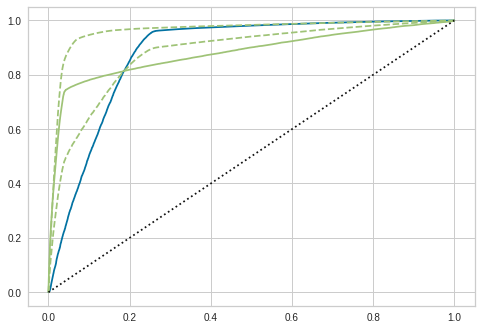

In [63]:
#ROC Curve
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(lr_model_final, classes=["nao_atraso", "atraso"])

visualizer.fit(cat_vars_ohe_2019_final, target_2019_final)         
visualizer.score(cat_vars_ohe_2020_final, target_2020_final)                                   
visualizer.show() 